Imports and General Setup

In [1]:


# Some standard pythonic imports
import warnings
warnings.filterwarnings('ignore')
import logging
import os,numpy as np,pandas as pd
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
from tqdm import tqdm
import json

# MNE library for EEG data analysis
import mne
from mne import Epochs,find_events
from mne.decoding import Vectorizer
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.preprocessing import ICA

from autoreject import AutoReject

# XDF file format support in MNE
import pyxdf
from mne_import_xdf import *

# Scikit-learn and Pyriemann for feature extraction and machine learning functionalities
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score,train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, train_test_split
from pyriemann.estimation import ERPCovariances, XdawnCovariances, Xdawn, Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

#import moab to get the filterbank implementation: 
from moabb.pipelines.utils import FilterBank

# For  GUI elements
from easygui import *

# For path manipulation
import pathlib
from os import listdir
from os.path import isfile, join

# For interactive plots
import PyQt5
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'qt')

#imports for precision_recall_curve related plot: 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score, precision_recall_curve,PrecisionRecallDisplay
from itertools import cycle
import matplotlib.pyplot as plt
import pickle

import copy


from braindecode.models import ShallowFBCSPNet
from braindecode.datautil import create_from_mne_epochs
from braindecode.training import CroppedLoss
from braindecode.training.scoring import trial_preds_from_window_preds
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch


from preprocessing import *
from training import *
from evaluation import *

# Define paths for data storage and processing
current_path = pathlib.Path().absolute()  
recording_path = current_path / 'Recordings'
figure_outputs_path=current_path / 'Figures'

#extract all recorded files and subject names
recording_files = [f for f in listdir(recording_path) if isfile(join(recording_path, f)) and ('.xdf' in f)]
if not(figure_outputs_path.exists()):
    print('the output folder does not exists:  ',figure_outputs_path)


print('all available recording files',recording_files)
subject_names=[r.split('_')[0] for r in recording_files]
print('only subjects IDS:',subject_names)

# Initial definitions: 

print('filenames:\n',recording_files)
print('names:\n',subject_names)


#define the electrode groups: the key can be anything, the values should be a list of electrodes
Electorde_Groups = {'FP': ['Fp1', 'Fp2'],
                   'AF': ['AF7', 'AF3', 'AFz', 'AF4', 'AF8'],
                   'F' : ['F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8'],
                   'FC': ['FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6'],
                   'C' : ['C5', 'C3', 'C1', 'Cz', 'C2', 'C4' ,'C6'],
                   'CP': ['CP5', 'CP3','CP1', 'CPz', 'CP2', 'CP4', 'CP6'],
                   'P' : ['P7','P5','P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8'],
                   'PO': ['PO7','PO3', 'POz', 'PO4', 'PO8'],
                   'O' : ['Oz', 'O2', 'O1', 'Iz']
                  } 

all available recording files ['Fudge_MI3_1.xdf', 'Fudge_MI3_2.xdf', 'Fudge_MI3_3.xdf', 'Fudge_MI3_4.xdf', 'g_mi_1.xdf', 'g_mi_3.xdf', 'g_mi_4.xdf']
only subjects IDS: ['Fudge', 'Fudge', 'Fudge', 'Fudge', 'g', 'g', 'g']
filenames:
 ['Fudge_MI3_1.xdf', 'Fudge_MI3_2.xdf', 'Fudge_MI3_3.xdf', 'Fudge_MI3_4.xdf', 'g_mi_1.xdf', 'g_mi_3.xdf', 'g_mi_4.xdf']
names:
 ['Fudge', 'Fudge', 'Fudge', 'Fudge', 'g', 'g', 'g']


Create a parameter dictionary 

In [250]:
params_dict={}
params_dict['PerformCsd']=True
Electorde_Group_Names='F+FC+C+CP+P+PO'
params_dict['Electorde_Group']=[] 
for cur_elec_group_name in Electorde_Group_Names.split('+'):
    params_dict['Electorde_Group']=params_dict['Electorde_Group']+Electorde_Groups[cur_elec_group_name]
params_dict['bad_electrodes'] = get_subject_bad_electrodes ('Fudge') # Manually define subject name
params_dict['filter_method']='fir'
params_dict['epoch_tmins_and_maxes_grid'] = [-3,5]
params_dict['epoch_tmin'] = -3
params_dict['epoch_tmax'] = 5
params_dict['n_components']= 10
params_dict['LowPass']=5
params_dict['HighPass']=35
params_dict['filters_bands']=[[7, 12], [12, 20], [20, 28], [28, 35]]
params_dict['augmentation_params']={'win_len': 1, 'win_step': 0.1}
params_dict['classifier_window_s']=1
params_dict['classifier_window_e']=3
params_dict['windowed_prediction_params']={'win_len': 2, 'win_step': 0.1}
params_dict['pipeline_name']='csp+lda'
params_dict['n_components_fbcsp']=10
params_dict['desired_events'] = ['ActiveRest','ClosePalm','OpenPalm','Rest'] 


Load XDF files and convert to combined mne Raw instance

In [251]:
xdf_files = [f for f in recording_path.glob('*.xdf') if 'Fudge' in  f.name] # fill in name to select subject files
#OriginalRaw = Load_and_concatenate_xdf(xdf_files)

In [252]:
epochs_list = []
filter_bank_epochs_list = []
for xdf_file in xdf_files:
    raw=read_raw_xdf(xdf_file)
    epoch,filter_bank_epochs,mean_across_epochs, events_trigger_dict = EEG_Preprocessing(current_path,raw,params_dict)
    epochs_list.append(epoch)
    filter_bank_epochs_list.append(filter_bank_epochs)

print("Concatenating all preprocessed epochs...")
epochs = mne.concatenate_epochs(epochs_list, on_mismatch='warn')
filter_bank_epochs = None

Creating RawArray with float64 data, n_channels=67, n_times=330327
    Range : 0 ... 330326 =      0.000 ...   660.652 secs
Ready.

###########################################################
removing subject specific bad electrodes from the raw data

###########################################################
removing bad channels from epochs:
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.

###########################################################
not using csd
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.

###########################################################
filtering the data
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rest']

###########################################################
extracting event info: {'ActiveRest': 1, 'Beep': 2, 'ClosePalm': 3, 'Long Break': 4, 'OpenPalm': 5, 'Rest': 6}

###########################################################
epoching + selecting current electodes set for analysis:
['F7', 'F5', 'F3', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8']
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 101 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.5s finished


0 bad epochs dropped
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm
ActiveRest
ClosePalm
OpenPalm
Rest
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated

###########################################################
removing bad channels from epochs:
Creating RawArray with float64 data, n_channels=67, n_times=454252
    Range : 0 ... 454251 =      0.000 ...   908.502 secs
Ready.

###########################################################
removing subject specific bad electrodes from the raw data

###########################################################
removing bad channels from epochs:
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.

###########################################################
not using csd
EEG channel type selected for re-referencing
Applying average reference.
Apply

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rest']

###########################################################
extracting event info: {'ActiveRest': 1, 'Beep': 2, 'ClosePalm': 3, 'Long Break': 4, 'OpenPalm': 5, 'Rest': 6}

###########################################################
epoching + selecting current electodes set for analysis:
['F7', 'F5', 'F3', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8']
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.6s finished


0 bad epochs dropped
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm
ActiveRest
ClosePalm
OpenPalm
Rest
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated

###########################################################
removing bad channels from epochs:
Creating RawArray with float64 data, n_channels=67, n_times=413262
    Range : 0 ... 413261 =      0.000 ...   826.522 secs
Ready.

###########################################################
removing subject specific bad electrodes from the raw data

###########################################################
removing bad channels from epochs:
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.

###########################################################
not using csd
EEG channel type selected for re-referencing
Applying average reference.
Apply

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rest']

###########################################################
extracting event info: {'ActiveRest': 1, 'Beep': 2, 'ClosePalm': 3, 'Long Break': 4, 'OpenPalm': 5, 'Rest': 6}

###########################################################
epoching + selecting current electodes set for analysis:
['F7', 'F5', 'F3', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8']
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.6s finished


0 bad epochs dropped
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm
ActiveRest
ClosePalm
OpenPalm
Rest
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated

###########################################################
removing bad channels from epochs:
Creating RawArray with float64 data, n_channels=67, n_times=404519
    Range : 0 ... 404518 =      0.000 ...   809.036 secs
Ready.

###########################################################
removing subject specific bad electrodes from the raw data

###########################################################
removing bad channels from epochs:
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.

###########################################################
not using csd
EEG channel type selected for re-referencing
Applying average reference.
Apply

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rest']

###########################################################
extracting event info: {'ActiveRest': 1, 'Beep': 2, 'ClosePalm': 3, 'Long Break': 4, 'OpenPalm': 5, 'Rest': 6}

###########################################################
epoching + selecting current electodes set for analysis:
['F7', 'F5', 'F3', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8']
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 114 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.6s finished


1 bad epochs dropped
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm
ActiveRest
ClosePalm
OpenPalm
Rest
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items activated

###########################################################
removing bad channels from epochs:
Concatenating all preprocessed epochs...
Not setting metadata
456 matching events found
No baseline correction applied


Pre-processing

In [253]:
events = epochs.events
event_dict = epochs.event_id
params_dict['events_trigger_dict'] = {key: event_dict[key] for key in event_dict.keys() if key in params_dict['desired_events']}
train_inds,validation_inds,return_dict = Split_training_validation (epochs,filter_bank_epochs, params_dict['events_trigger_dict'])
epochs_copy = epochs.copy()
returned_dict=crop_the_data(epochs_copy,train_inds,validation_inds,params_dict['classifier_window_s'],params_dict['classifier_window_e']) #two more paramters here are tmin and tmax which are not used apparently. 
train_set_data_uncropped=returned_dict['train_set_data_uncropped']
epochs_cropped=returned_dict['epochs_cropped']
train_set_data=returned_dict['train_set_data']
train_set_labels=returned_dict['train_set_labels']

validation_set_labels=returned_dict['validation_set_labels']
validation_set_data_uncropped=returned_dict['validation_set_data_uncropped']
#define cv on the data: 
cv = StratifiedShuffleSplit(5, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_cropped.get_data(),events[:,2])

#filter bank related:
if params_dict['pipeline_name']=='fbcsp+lda': 
    train_set_data_fb=[]
    train_set_data_uncropped_fb=[]
    validation_set_data_fb=[]
    validation_set_data_uncropped_fb=[]
    for filtered_data_band_epoch in preprocessing_dict['filter_bank_epochs']:
        returned_dict_temp=crop_the_data(filtered_data_band_epoch,train_inds,validation_inds, params_dict['classifier_window_s'],params_dict['classifier_window_e'])
        #extract the train set data: 
        train_set_data_uncropped_temp=returned_dict_temp['train_set_data_uncropped']
        train_set_data_temp=returned_dict_temp['train_set_data']
        train_set_data_fb.append(train_set_data_temp)
        train_set_data_uncropped_fb.append(train_set_data_uncropped_temp)
        #extract the validation set data: 
        validation_set_data_uncroped_temp=returned_dict_temp['validation_set_data_uncroped']
        validation_set_data_temp=returned_dict_temp['validation_set_data']
        validation_set_data_fb.append(validation_set_data_temp)
        validation_set_data_uncropped_fb.append(validation_set_data_uncroped_temp)
    #create a 4d matrix of train data:     
    train_set_data_4d_array= np.transpose(np.array(train_set_data_fb),(1,2,3,0))
    train_set_data_uncropped_4d_array=np.transpose(np.array(train_set_data_uncropped_fb),(1,2,3,0)) 
    train_set_data=train_set_data_4d_array
    train_set_data_uncropped=train_set_data_uncropped_4d_array
    #create a 4d matrix of validation data: 
    validation_set_data_4d_array= np.transpose(np.array(validation_set_data_fb),(1,2,3,0))
    validation_set_data_uncropped_4d_array=np.transpose(np.array(validation_set_data_uncropped_fb),(1,2,3,0)) 
    validation_set_data_uncropped=validation_set_data_uncropped_4d_array


augmented_x,augmented_y = augment_data(params_dict['augmentation_params'], train_set_data,train_set_labels,epochs.info['sfreq'])

triggers_label_dict={val:key for key,val in params_dict['events_trigger_dict'].items()} 
test_data_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in validation_set_labels])  
augmented_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in augmented_y])  


putting aside 20% of the data: trial numbers are:
 [ 76 130 323 450 401 278  99 355 256  59 224 292  72   2   7 101 433 440
 376 286   9 251   5 231 158  39 432  82 430 300 144 316 453 315 146 419
  75 455  16 152  57 397 408 313 294 105  12 352 273 302 378 350  94  85
 254 117  20 309 238 229 195 134 369  21 177 161 147 393 260 407 178 249
 160 230 454  49 356 334 436 222 320  45 189 172 205 182   1 364 445 318
 379 424]

remaining 80% of the trials go into training for cv:
 [400 353 365 235 423 169 240  84 153 245  11 282 272 201  26  70 120 174
  92 258 104 261 403 122 248 361 428 434 297  19 290  86 359 180  50 391
  68  95  87   8 142 388 197 227  79 285 202 351  83 157 404 216 448 342
 409 346 411 389 339 390  38  18 303 167  69 137 415 332 438  60 426 246
 237 207 118 126 299  97  74 236  65 173  91 138 327 132 225  47 215 304
 338 250 312 373 111 275  63 232  24 362 306 289 293 186  93 421 437 329
 371 184 234 451 344 413 333 394 331  55 412  62 360 383  31 183 114  58
 416 190

Cross-Validation Evaluation 

In [254]:
scores_windows,folds_confusion_matrices_per_window,w_times= run_windowed_classification_aug_cv(epochs, returned_dict['epochs_cropped'], cv_split,params_dict)

Computing rank from data with rank=None
    Using tolerance 0.078 (2.2e-16 eps * 42 dim * 8.3e+12  max singular value)
    Estimated rank (mag): 42
    MAG: rank 42 computed from 42 data channels with 0 projectors
Reducing data rank from 42 -> 42
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.079 (2.2e-16 eps * 42 dim * 8.5e+12  max singular value)
    Estimated rank (mag): 42
    MAG: rank 42 computed from 42 data channels with 0 projectors
Reducing data rank from 42 -> 42
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.08 (2.2e-16 eps * 42 dim * 8.5e+12  max singular value)
    Estimated rank (mag): 42
    MAG: rank 42 computed from 42 data channels with 0 projectors
Reducing data rank from 42 -> 42
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.15 (2.2e-16 eps * 42 dim * 1.6e+13  max singular value)
    Estimated rank (mag): 42

In [255]:
plot_accuracy_over_time(scores_windows, w_times, params_dict, axes_handle=None)

In [249]:
w_step = int(500 * 0.1)   # running classifier: window length
w_length = int(500 * 2)
w_start = np.arange(0, epochs.get_data().shape[2] - w_length, w_step)

In [112]:
w_times = (w_start + w_length / 2.) / 500 + params_dict['epoch_tmin']


In [113]:
w_start

array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
       1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600,
       1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150,
       2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700,
       2750, 2800, 2850, 2900, 2950, 3000])

Training

In [126]:
clf,csp,lda = classifier_training(augmented_x,augmented_y,params_dict, BinaryClassification = False)

Computing rank from data with rank=None
    Using tolerance 0.095 (2.2e-16 eps * 40 dim * 1.1e+13  max singular value)
    Estimated rank (mag): 40
    MAG: rank 40 computed from 40 data channels with 0 projectors
Reducing data rank from 40 -> 40
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.082 (2.2e-16 eps * 40 dim * 9.2e+12  max singular value)
    Estimated rank (mag): 40
    MAG: rank 40 computed from 40 data channels with 0 projectors
Reducing data rank from 40 -> 40
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.088 (2.2e-16 eps * 40 dim * 9.9e+12  max singular value)
    Estimated rank (mag): 40
    MAG: rank 40 computed from 40 data channels with 0 projectors
Reducing data rank from 40 -> 40
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.28 (2.2e-16 eps * 40 dim * 3.2e+13  max singular value)
    Estimated rank (mag): 4

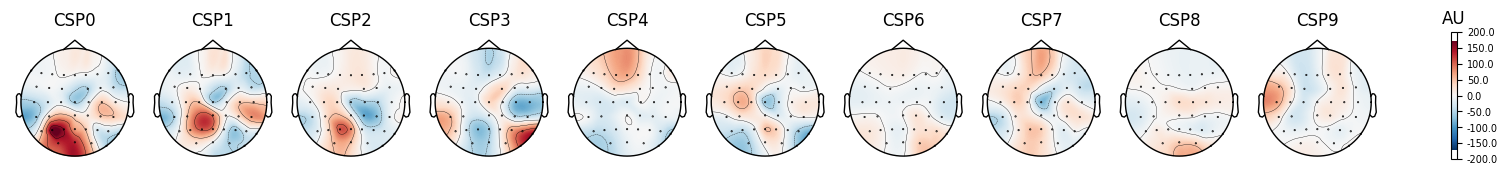

In [127]:
csp.plot_patterns(epochs.info)

In [130]:
w_length = int(raw.info['sfreq'] * params_dict['windowed_prediction_params']['win_len'])   # running classifier: window length
w_step = int(raw.info['sfreq'] * params_dict['windowed_prediction_params']['win_step'])  # running classifier: window step size
w_start = np.arange(0, train_set_data_uncropped.shape[2] - w_length, w_step)
w_times = (w_start + w_length / 2.) / raw.info['sfreq'] + params_dict['epoch_tmin']

In [131]:
scores_per_time_window,confusion_matrices_per_window = run_windowed_pretrained_classifier(clf,validation_set_data_uncropped,test_data_y_labels,w_start,w_length)


Class order in confusion matrix: ['ActiveRest' 'ClosePalm' 'OpenPalm' 'Rest']


In [7]:
plot_accuracy_over_time(scores_per_time_window, w_times, params_dict, axes_handle=None)

NameError: name 'scores_per_time_window' is not defined

In [38]:
train_set_data_uncropped.shape[2] + 500- w_length

3501

In [22]:
scores_windows_array = np.squeeze(np.array(scores_per_time_window))

In [23]:
scores_windows_array.shape

(71,)

In [144]:
confusion_matrices_per_window

[(array([[ 3,  0,  0,  7],
         [ 1,  1,  1,  7],
         [ 1,  0,  2,  8],
         [ 4,  4,  5, 18]], dtype=int64),
  array(['ActiveRest', 'ClosePalm', 'OpenPalm', 'Rest'], dtype='<U10')),
 (array([[ 3,  0,  0,  7],
         [ 1,  1,  1,  7],
         [ 2,  0,  1,  8],
         [ 5,  5,  4, 17]], dtype=int64),
  array(['ActiveRest', 'ClosePalm', 'OpenPalm', 'Rest'], dtype='<U10')),
 (array([[ 2,  0,  1,  7],
         [ 1,  1,  1,  7],
         [ 2,  0,  1,  8],
         [ 5,  4,  3, 19]], dtype=int64),
  array(['ActiveRest', 'ClosePalm', 'OpenPalm', 'Rest'], dtype='<U10')),
 (array([[ 2,  0,  1,  7],
         [ 2,  1,  1,  6],
         [ 2,  0,  1,  8],
         [ 6,  4,  2, 19]], dtype=int64),
  array(['ActiveRest', 'ClosePalm', 'OpenPalm', 'Rest'], dtype='<U10')),
 (array([[ 3,  0,  1,  6],
         [ 2,  1,  2,  5],
         [ 2,  0,  1,  8],
         [ 6,  4,  2, 19]], dtype=int64),
  array(['ActiveRest', 'ClosePalm', 'OpenPalm', 'Rest'], dtype='<U10')),
 (array([[ 2,  0,  2

In [147]:
import numpy as np

def merge_conf_matrix_tuple(conf_matrix_tuple):
    """
    Converts a 4-class confusion matrix into a 2-class confusion matrix
    by merging:
    - 'ActiveRest' (0) & 'Rest' (3) → Class 0
    - 'ClosePalm' (1) & 'OpenPalm' (2) → Class 1

    Args:
    conf_matrix_tuple (tuple): (4x4 confusion matrix, class labels)

    Returns:
    tuple: (2x2 merged confusion matrix, new class labels)
    """
    cm_4class, class_labels = conf_matrix_tuple  # Extract confusion matrix & labels

    # Merge rows (true labels)
    row_0 = cm_4class[0] + cm_4class[3]  # Merge 'ActiveRest' (0) & 'Rest' (3)
    row_1 = cm_4class[1] + cm_4class[2]  # Merge 'ClosePalm' (1) & 'OpenPalm' (2)

    # Merge columns (predicted labels)
    col_0 = row_0[0] + row_0[3]  # Merge predictions for 'ActiveRest' (0) & 'Rest' (3)
    col_1 = row_0[1] + row_0[2]  # Merge predictions for 'ClosePalm' (1) & 'OpenPalm' (2)
    col_2 = row_1[0] + row_1[3]  # Merge predictions for 'ActiveRest' (0) & 'Rest' (3)
    col_3 = row_1[1] + row_1[2]  # Merge predictions for 'ClosePalm' (1) & 'OpenPalm' (2)

    # Construct new 2x2 confusion matrix
    cm_binary = np.array([
        [col_0, col_1],  # Row 0 (New Class 0)
        [col_2, col_3]   # Row 1 (New Class 1)
    ])

    return (cm_binary, np.array(['rest', 'motor_imagery']))

# Example: Apply to all confusion matrices in the list
conf_matrices_merged = [merge_conf_matrix_tuple(cm_tuple) for cm_tuple in confusion_matrices_per_window]

# Print merged confusion matrices
for i, (cm_bin, labels) in enumerate(conf_matrices_merged):
    print(f"\nBinary Confusion Matrix (Window {i+1}):")
    print(cm_bin)
    print("New Labels:", labels)



Binary Confusion Matrix (Window 1):
[[32  9]
 [17  4]]
New Labels: ['rest' 'motor_imagery']

Binary Confusion Matrix (Window 2):
[[32  9]
 [18  3]]
New Labels: ['rest' 'motor_imagery']

Binary Confusion Matrix (Window 3):
[[33  8]
 [18  3]]
New Labels: ['rest' 'motor_imagery']

Binary Confusion Matrix (Window 4):
[[34  7]
 [18  3]]
New Labels: ['rest' 'motor_imagery']

Binary Confusion Matrix (Window 5):
[[34  7]
 [17  4]]
New Labels: ['rest' 'motor_imagery']

Binary Confusion Matrix (Window 6):
[[32  9]
 [18  3]]
New Labels: ['rest' 'motor_imagery']

Binary Confusion Matrix (Window 7):
[[30 11]
 [17  4]]
New Labels: ['rest' 'motor_imagery']

Binary Confusion Matrix (Window 8):
[[31 10]
 [17  4]]
New Labels: ['rest' 'motor_imagery']

Binary Confusion Matrix (Window 9):
[[32  9]
 [18  3]]
New Labels: ['rest' 'motor_imagery']

Binary Confusion Matrix (Window 10):
[[30 11]
 [18  3]]
New Labels: ['rest' 'motor_imagery']

Binary Confusion Matrix (Window 11):
[[30 11]
 [19  2]]
New Labels: 

In [163]:
import numpy as np

def average_conf_matrix(conf_matrices_merged, start_idx, end_idx):
    """
    Computes the average confusion matrix over a given index range.

    Args:
    conf_matrices_merged (list of tuples): [(2x2 confusion matrix, labels), ...]
    start_idx (int): Start index for averaging.
    end_idx (int): End index for averaging (inclusive).

    Returns:
    tuple: (Averaged 2x2 confusion matrix, class labels)
    """
    # Extract only the confusion matrices from the selected range
    selected_matrices = [cm[0] for cm in conf_matrices_merged[start_idx:end_idx+1]]

    # Convert to numpy array and compute the mean
    avg_conf_matrix = np.mean(np.array(selected_matrices), axis=0)

    # Round values to nearest integer (optional)
    avg_conf_matrix = np.round(avg_conf_matrix).astype(int)

    # Extract class labels (assume they're the same for all matrices)
    class_labels = conf_matrices_merged[0][1]

    return avg_conf_matrix, class_labels

# Example: Compute the average confusion matrix from index 2 to 5
start_idx, end_idx = 30, 71
avg_conf_matrix, avg_labels = average_conf_matrix(conf_matrices_merged, start_idx, end_idx)

# Print result
print("\nAverage Confusion Matrix (From Index", start_idx, "to", end_idx, "):")
print(avg_conf_matrix)
print("Labels:", avg_labels)



Average Confusion Matrix (From Index 30 to 71 ):
[[35  6]
 [ 7 14]]
Labels: ['rest' 'motor_imagery']


In [267]:
def merge_conf_matrix_tuple(conf_matrix_tuple):
    """
    Converts a 4-class confusion matrix into a 2-class confusion matrix
    by merging:
    - 'ActiveRest' (0) & 'Rest' (3) → Class 0
    - 'ClosePalm' (1) & 'OpenPalm' (2) → Class 1

    Args:
    conf_matrix_tuple (tuple): (4x4 confusion matrix, class labels)

    Returns:
    tuple: (2x2 merged confusion matrix, new class labels)
    """
    cm_4class, class_labels = conf_matrix_tuple  # Extract confusion matrix & labels

    # Merge rows (true labels)
    row_0 = cm_4class[0] + cm_4class[3]  # Merge 'ActiveRest' (0) & 'Rest' (3)
    row_1 = cm_4class[1] + cm_4class[2]  # Merge 'ClosePalm' (1) & 'OpenPalm' (2)

    # Merge columns (predicted labels)
    col_0 = row_0[0] + row_0[3]  # Merge predictions for 'ActiveRest' (0) & 'Rest' (3)
    col_1 = row_0[1] + row_0[2]  # Merge predictions for 'ClosePalm' (1) & 'OpenPalm' (2)
    col_2 = row_1[0] + row_1[3]  # Merge predictions for 'ActiveRest' (0) & 'Rest' (3)
    col_3 = row_1[1] + row_1[2]  # Merge predictions for 'ClosePalm' (1) & 'OpenPalm' (2)

    # Construct new 2x2 confusion matrix
    cm_binary = np.array([
        [col_0, col_1],  # Row 0 (New Class 0)
        [col_2, col_3]   # Row 1 (New Class 1)
    ])

    return (cm_binary, np.array(['rest', 'motor_imagery']))

# Example: Apply to all confusion matrices in all folds
conf_matrices_merged_all_folds = [
    [merge_conf_matrix_tuple(cm_tuple) for cm_tuple in fold] for fold in folds_confusion_matrices_per_window
]

def average_conf_matrix_folds(conf_matrices_all_folds, start_idx, end_idx):
    """
    Computes the average confusion matrix over multiple folds 
    for a given index range.

    Args:
    conf_matrices_all_folds (list of list of tuples): 
        A nested list where each fold contains a list of (confusion_matrix, labels).
    start_idx (int): Start index for averaging.
    end_idx (int): End index for averaging (inclusive).

    Returns:
    tuple: (Averaged 2x2 confusion matrix, class labels)
    """
    all_selected_matrices = []  # Store matrices from all folds
    valid_folds = 0  # Count number of folds that have valid data in range

    # Iterate through each fold
    for fold in conf_matrices_all_folds:
        # Ensure the fold has enough matrices for the given index range
        if len(fold) > end_idx:
            selected_matrices = [cm_tuple[0] for cm_tuple in fold[start_idx:end_idx+1]]
            all_selected_matrices.append(np.mean(selected_matrices, axis=0))  # Average over the time window in fold
            valid_folds += 1

    # Compute final average across valid folds
    if valid_folds > 0:
        avg_conf_matrix = np.mean(np.array(all_selected_matrices), axis=0)
    else:
        print("No valid folds for the given index range!")
        return None, None

    # Round values to nearest integer (optional)
    avg_conf_matrix = np.round(avg_conf_matrix).astype(int)

    # Extract class labels (assume same for all folds)
    class_labels = conf_matrices_all_folds[0][0][1]

    return avg_conf_matrix, class_labels

# Example: Compute the average confusion matrix from index 2 to 5 across folds
start_idx, end_idx = 30,60
avg_conf_matrix, avg_labels = average_conf_matrix_folds(conf_matrices_merged_all_folds, start_idx, end_idx)

# Print result
print("\nAverage Confusion Matrix (Across Folds, From Index", start_idx, "to", end_idx, "):")
print(avg_conf_matrix)
print("Labels:", avg_labels)



Average Confusion Matrix (Across Folds, From Index 30 to 60 ):
[[54  7]
 [ 9 22]]
Labels: ['rest' 'motor_imagery']


In [158]:
len(conf_matrices_merged)

71

In [138]:

# Example: Plot confusion matrix for the first time window
conf_matrix, class_labels = confusion_matrices_per_window[41]
plot_confusion_matrix(conf_matrix, class_labels)

In [92]:
scores_per_time_window

[0.5238095238095238,
 0.47619047619047616,
 0.5238095238095238,
 0.5238095238095238,
 0.5714285714285714,
 0.5714285714285714,
 0.6190476190476191,
 0.47619047619047616,
 0.5238095238095238,
 0.5714285714285714,
 0.5238095238095238,
 0.47619047619047616,
 0.38095238095238093,
 0.42857142857142855,
 0.47619047619047616,
 0.5238095238095238,
 0.5714285714285714,
 0.5238095238095238,
 0.47619047619047616,
 0.47619047619047616,
 0.5238095238095238,
 0.6190476190476191,
 0.5238095238095238,
 0.6190476190476191,
 0.6666666666666666,
 0.6190476190476191,
 0.7142857142857143,
 0.6666666666666666,
 0.6666666666666666,
 0.8095238095238095,
 0.7619047619047619,
 0.7619047619047619,
 0.7619047619047619,
 0.7619047619047619,
 0.7142857142857143,
 0.7619047619047619,
 0.7619047619047619,
 0.8095238095238095,
 0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.9047619047619048,
 0.8571428571428571,
 0.7619047619047619,
 0.8571428571428571,
 0.7619047619047619,
 0.7142857142857143,
 0.66

In [52]:
scores_per_time_window


[0.3142857142857143,
 0.37142857142857144,
 0.34285714285714286,
 0.3142857142857143,
 0.34285714285714286,
 0.34285714285714286,
 0.4,
 0.4857142857142857,
 0.4857142857142857,
 0.4857142857142857,
 0.42857142857142855,
 0.4,
 0.42857142857142855,
 0.4,
 0.45714285714285713,
 0.42857142857142855,
 0.45714285714285713,
 0.42857142857142855,
 0.42857142857142855,
 0.4857142857142857,
 0.4857142857142857,
 0.4857142857142857,
 0.4857142857142857,
 0.4857142857142857,
 0.45714285714285713,
 0.4857142857142857,
 0.4857142857142857,
 0.45714285714285713,
 0.42857142857142855,
 0.45714285714285713,
 0.5142857142857142,
 0.6,
 0.5714285714285714,
 0.5142857142857142,
 0.5428571428571428,
 0.5142857142857142,
 0.5714285714285714,
 0.6,
 0.5714285714285714,
 0.5714285714285714,
 0.5428571428571428,
 0.5428571428571428,
 0.5428571428571428,
 0.5142857142857142,
 0.5428571428571428,
 0.5142857142857142,
 0.45714285714285713,
 0.45714285714285713,
 0.45714285714285713,
 0.42857142857142855,
 0.485

In [118]:
def average_from_index_to_index(lst, start, end):
    # Ensure the indices are within the bounds of the list
    if start < 0 or end >= len(lst) or start > end:
        raise ValueError("Invalid start or end index")
    
    # Slice the list from start to end (inclusive)
    sublist = lst[start:end+1]
    
    # Calculate the average
    average = sum(sublist) / len(sublist)
    
    return average

# Example usage
start_index = 40
end_index =70
print(average_from_index_to_index(scores_per_time_window, start_index, end_index))  # Output: 35.0

0.5587929240374611


In [119]:
# Time points (assuming each point is 100 ms apart)
time_points = np.arange(0, len(scores_per_time_window) * 0.1, 0.1)  # in seconds

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_points, scores_per_time_window, marker='o')
plt.title('Sliding Window Scores Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Score')
plt.grid(True)
plt.show()

In [246]:
all_epoch_data = epochs.get_data()

In [247]:

scaler = RobustScaler()
all_epoch_data_flat = all_epoch_data.reshape(all_epoch_data.shape[0], -1)
all_epoch_data_normalized = scaler.fit_transform(all_epoch_data_flat).reshape(all_epoch_data.shape)

# Update combined epochs with normalized data
epochs._data = all_epoch_data_normalized

In [22]:
from sklearn.preprocessing import StandardScaler, RobustScaler


In [29]:
loaded_epochs = mne.read_epochs('epochs_combined-epo2.fif', preload=True)

Reading c:\Users\gilad\3_Class_MI_21_01_25\epochs_combined-epo2.fif ...
    Found the data of interest:
        t =   -3000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
